In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
directory = "../archive/PlantVillage"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

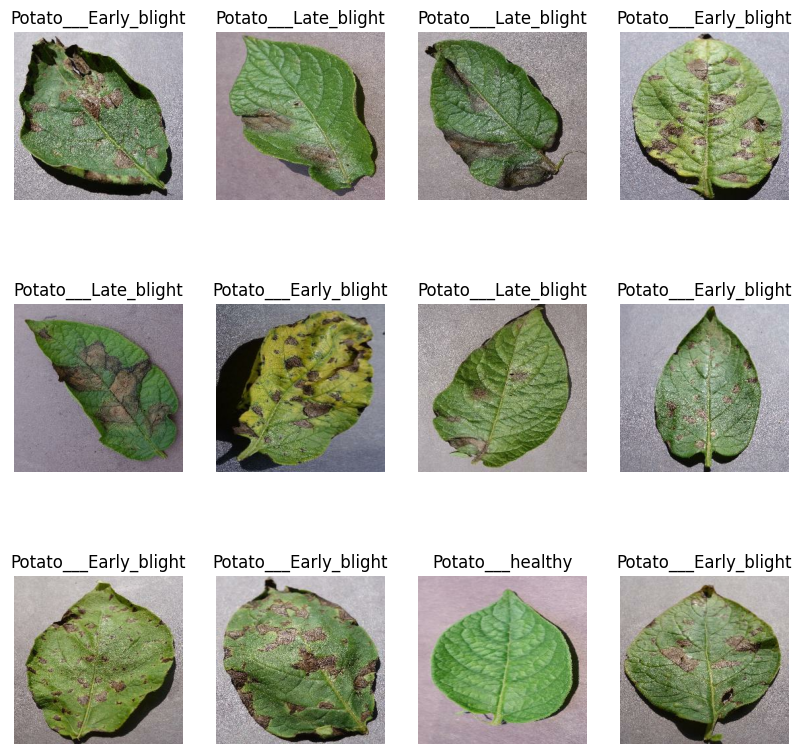

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)   
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 

In [6]:
len(dataset)

68

In [7]:
#80% as training
#20%: 10% validation 10% testing

In [8]:
train_size = 0.8
train_dataset = dataset.take(54)
len(train_dataset)


54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)
val_size = 0.1
len(dataset)*val_size


6.800000000000001

In [10]:
val_dataset = test_ds.take(6)
test_dataset = test_ds.skip(6) 

In [11]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle= True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    validation_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(validation_size) 
    test_ds = ds.skip(train_size).take(validation_size)
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)


54

In [14]:
len(val_ds)


6

In [15]:
len(test_ds)

6

In [16]:
#optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) #cpu loading the batch
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) #cpu loading the batch
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) #cpu loading the batch

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


In [19]:
train_ds = train_ds.map(
    lambda x,y : (data_augmentation(x,training= True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\archi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 633ms/step - accuracy: 0.4837 - loss: 0.9500 - val_accuracy: 0.5434 - val_loss: 0.8940
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 673ms/step - accuracy: 0.5658 - loss: 0.8645 - val_accuracy: 0.7269 - val_loss: 0.7674
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 760ms/step - accuracy: 0.7923 - loss: 0.5636 - val_accuracy: 0.7992 - val_loss: 0.4936
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 702ms/step - accuracy: 0.8217 - loss: 0.4244 - val_accuracy: 0.8791 - val_loss: 0.3195
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 763ms/step - accuracy: 0.8794 - loss: 0.3290 - val_accuracy: 0.9306 - val_loss: 0.1891
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 768ms/step - accuracy: 0.9172 - loss: 0.1944 - val_accuracy: 0.9450 - val_loss: 0.1467
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 687ms/step - accuracy: 0.9376 - loss: 0.1773 - val_accuracy: 0.9450 - val_loss: 0.1555
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 719ms/step - accuracy: 0.9427 - loss: 0.1502 - val_accu

In [24]:
history

In [25]:
scores = model.evaluate(test_ds)

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9860 - loss: 0.0389


In [26]:
scores

[0.04638376459479332, 0.9826388955116272]

In [27]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
history.history['accuracy']

[0.47337964177131653,
 0.5896990895271301,
 0.7910879850387573,
 0.8559027910232544,
 0.8790509104728699,
 0.9282407164573669,
 0.9328703880310059,
 0.9328703880310059,
 0.9421296119689941,
 0.9502314925193787,
 0.9473379850387573,
 0.9565972089767456,
 0.9554398059844971,
 0.9484953880310059,
 0.9751157164573669,
 0.9803240895271301,
 0.9710648059844971,
 0.9745370149612427,
 0.9751157164573669,
 0.9774305820465088,
 0.9907407164573669,
 0.9861111044883728,
 0.9837962985038757,
 0.9907407164573669,
 0.9785879850387573,
 0.9820601940155029,
 0.9780092835426331,
 0.9826388955116272,
 0.9878472089767456,
 0.9890046119689941]

Text(0.5, 1.0, 'training and validation accuracy')

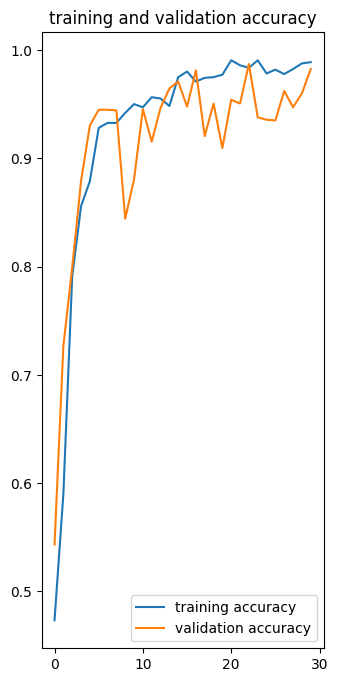

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc , label = 'training accuracy')
plt.plot(range(EPOCHS), val_acc, label= 'validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

#loss chart will be negative going closer to 0

first image to predict
first image's actual label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
predicted label:  Potato___Early_blight


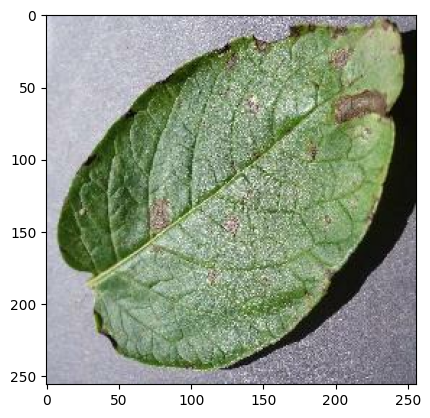

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)

    print('predicted label: ' , class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i]. numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)

    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


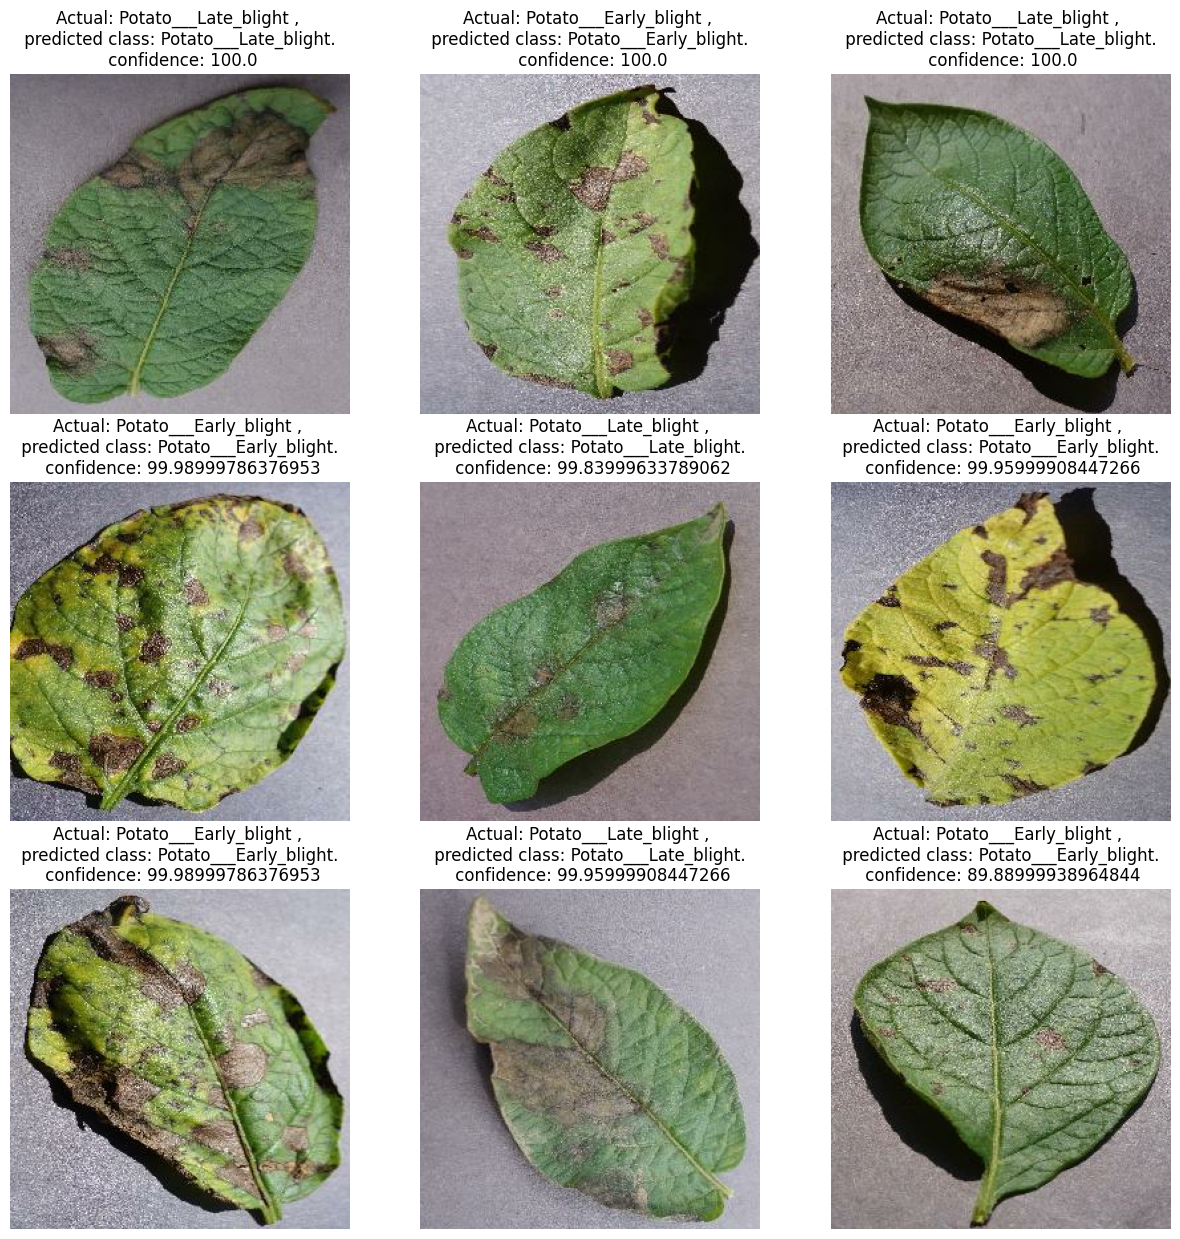

In [33]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class} , \n predicted class: {predicted_class}. \n confidence: {confidence}")
        plt.axis('off')
        

In [34]:
model_version = 1
model.save(f"../models/{model_version}.keras")